# Manga translation pipline prototype

### Import necessary libraries

In [43]:
from inference import get_model
import supervision as sv
import cv2
from PIL import Image
import numpy as np
import easyocr
import matplotlib.pyplot as plt

In [ ]:
import json
import os

# Load configuration from config.json
with open("config.json", "r", encoding="utf-8") as f:
    config = json.load(f)

API_KEYS = config["API_KEYS"]
IMPORT_PARAMS = config["IMPORT_PARAMS"]

In [44]:
# Import API keys from external file (do not commit api_keys.py to git!)
from api_keys import API_KEYS

### Load Image Once

In [ ]:
input_file_name = IMPORT_PARAMS.get("input_file_name", "p (1)")
input_file_extension = IMPORT_PARAMS.get("default_image_extension", "jpg")
input_folder = IMPORT_PARAMS.get("input_folder", "inputs")
image_path = os.path.join(input_folder, f"{input_file_name}.{input_file_extension}")
pil_image = Image.open(image_path).convert("RGB")
cv2_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)  # For OpenCV use
display_image = cv2_image.copy()  # For visualization

### Display Original Image

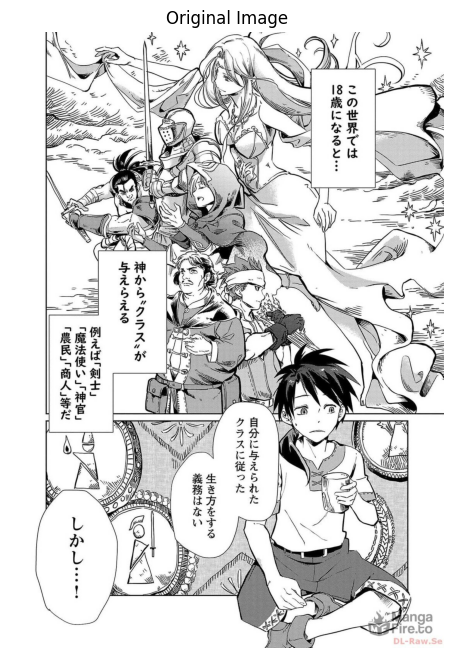

In [46]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.show()

# Part 1: Find text areas

### Inference with Model

In [47]:
API_KEY = API_KEYS["INFERENCE_API_KEY"]
model = get_model(model_id="manga-text-detection-xyvbw/2", api_key=API_KEY)
results = model.infer(pil_image)[0]
detections = sv.Detections.from_inference(results)

# Draw Part 1 boxes (from model)
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
display_image = box_annotator.annotate(scene=display_image, detections=detections)
display_image = label_annotator.annotate(scene=display_image, detections=detections)

### EasyOCR

In [48]:
reader = easyocr.Reader(['ja'])
result = reader.detect(cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB), link_threshold=5, text_threshold=0.3)
easyocr_boxes = result[0][0]  # [x_min, x_max, y_min, y_max]

# Draw Part 2 boxes
for box in easyocr_boxes:
    x_min, x_max, y_min, y_max = box
    top_left = (int(x_min), int(y_min))
    bottom_right = (int(x_max), int(y_max))

    cv2.rectangle(display_image, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(display_image, "TextArea", (int(x_min), int(y_min) - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


### Display Combined Result 

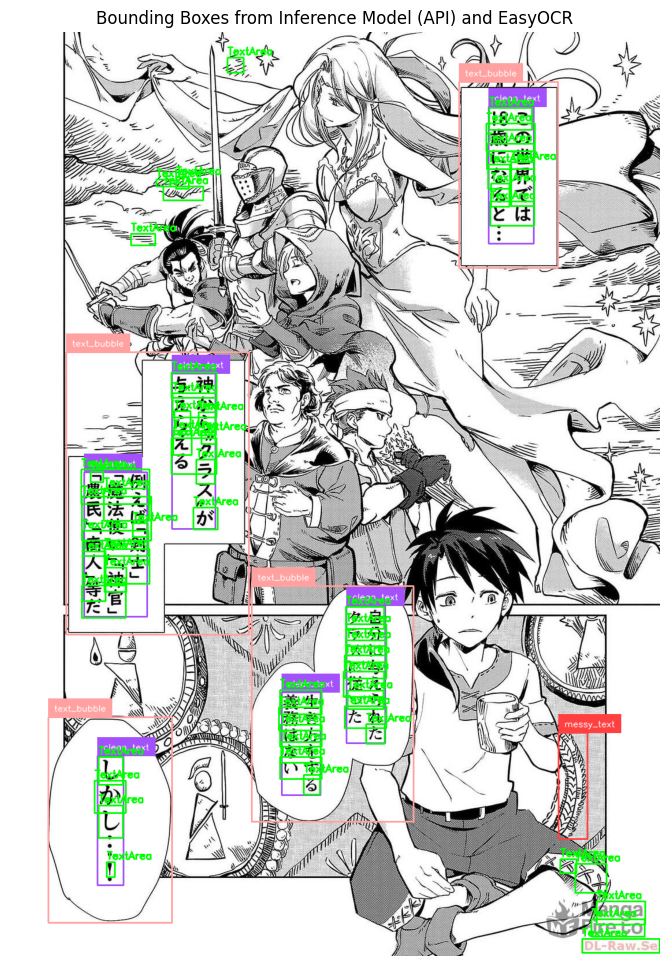

In [49]:
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
plt.title("Bounding Boxes from Inference Model (API) and EasyOCR")
plt.axis("off")
plt.show()

### Build hierarchy structure

In [50]:
#...

# Define a simple Box class to keep things clean
class Box:
    def __init__(self, bbox, box_type):
        self.bbox = [int(x) for x in bbox]
        self.type = box_type  # 'text_bubble', 'clean_text', 'messy_text', 'text_area'
        self.children = []

    def can_be_child_of(self, parent_type):
        if self.type == "text_area":
            return parent_type in ["clean_text", "messy_text", "text_bubble"]
        elif self.type in ["clean_text", "messy_text"]:
            return parent_type == "text_bubble"
        elif self.type == "text_bubble":
            return False
        return False

    def preferred_parent_order(self):
        if self.type == "text_area":
            return ["clean_text", "messy_text", "text_bubble"]
        elif self.type in ["clean_text", "messy_text"]:
            return ["text_bubble"]
        return []

    def to_dict(self):
        return {
            "type": self.type,
            "bbox": [int(x) for x in self.bbox],
            "children": [child.to_dict() for child in self.children]
        }


def is_inside(parent_bbox, child_bbox, margin=0.5):
    px_min, py_min, px_max, py_max = [int(x) for x in parent_bbox]
    cx_min, cy_min, cx_max, cy_max = [int(x) for x in child_bbox]

    child_area = (cx_max - cx_min) * (cy_max - cy_min)

    ix_min = max(px_min, cx_min)
    iy_min = max(py_min, cy_min)
    ix_max = min(px_max, cx_max)
    iy_max = min(py_max, cy_max)

    if ix_min >= ix_max or iy_min >= iy_max:
        return False

    intersection_area = (ix_max - ix_min) * (iy_max - iy_min)
    return (intersection_area / child_area) >= margin


def build_hierarchy(boxes):
    boxes = [Box(bbox=box["bbox"], box_type=box["type"]) for box in boxes]

    def find_parent(candidate, potential_parents):
        for preferred_type in candidate.preferred_parent_order():
            best_parent = None
            for parent in potential_parents:
                if parent.type != preferred_type:
                    continue
                if not candidate.can_be_child_of(parent.type):
                    continue
                if is_inside(parent.bbox, candidate.bbox):
                    for child in parent.children:
                        deeper_parent = find_parent(candidate, [child])
                        if deeper_parent:
                            return deeper_parent
                    best_parent = parent
            if best_parent:
                return best_parent
        return None

    hierarchy = []

    for candidate in boxes:
        parent = find_parent(candidate, hierarchy)
        if parent:
            parent.children.append(candidate)
        else:
            if candidate.type != "text_bubble":
                parentless = find_parent(candidate, boxes)
                if parentless:
                    parentless.children.append(candidate)
                    continue
            hierarchy.append(candidate)

    return [node.to_dict() for node in hierarchy]


def convert_supervision_to_boxes(detections):
    all_boxes = []
    for bbox, cls_name in zip(detections.xyxy, detections.data['class_name']):
        box_dict = {
            "bbox": [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])],
            "type": cls_name
        }
        all_boxes.append(box_dict)
    return all_boxes


def convert_easyocr_to_boxes(easyocr_boxes):
    all_boxes = []
    for box in easyocr_boxes:
        x_min, x_max = min(box[0], box[1]), max(box[0], box[1])
        y_min, y_max = min(box[2], box[3]), max(box[2], box[3])
        box_dict = {
            "bbox": [int(x_min), int(y_min), int(x_max), int(y_max)],
            "type": "text_area"
        }
        all_boxes.append(box_dict)
    return all_boxes


def create_final_hierarchy(detections, easyocr_boxes):
    supervision_boxes = convert_supervision_to_boxes(detections)
    easyocr_box_data = convert_easyocr_to_boxes(easyocr_boxes)
    combined_boxes = supervision_boxes + easyocr_box_data
    return build_hierarchy(combined_boxes)


def draw_hierarchy(image, hierarchy, level=0, color_map=None):
    import cv2

    if color_map is None:
        color_map = {
            "text_bubble": (255, 0, 0),
            "clean_text": (0, 255, 0),
            "messy_text": (0, 0, 255),
            "text_area": (255, 255, 0)
        }

    def draw_node(img, node, level):
        color = color_map.get(node["type"], (255, 255, 255))
        x_min, y_min, x_max, y_max = [int(x) for x in node["bbox"]]
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(img, f'{node["type"]} (L{level})', (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
        for child in node["children"]:
            draw_node(img, child, level + 1)

    for node in hierarchy:
        draw_node(image, node, level)

    return image


# Example usage with real detections:
hierarchy = create_final_hierarchy(detections, easyocr_boxes)
import json
print(json.dumps(hierarchy, indent=2))


[
  {
    "type": "text_bubble",
    "bbox": [
      66,
      1186,
      280,
      1542
    ],
    "children": [
      {
        "type": "clean_text",
        "bbox": [
          151,
          1253,
          196,
          1477
        ],
        "children": [
          {
            "type": "text_area",
            "bbox": [
              153,
              1255,
              195,
              1303
            ],
            "children": []
          },
          {
            "type": "text_area",
            "bbox": [
              146,
              1296,
              200,
              1352
            ],
            "children": []
          },
          {
            "type": "text_area",
            "bbox": [
              153,
              1339,
              195,
              1395
            ],
            "children": []
          },
          {
            "type": "text_area",
            "bbox": [
              167,
              1437,
              181,
            

### Morph bounding boxes

In [51]:
# --- Expand Parent Boxes ---
def expand_parents(hierarchy):
    def expand_node(node):
        if node["type"] not in ["clean_text", "messy_text"]:
            for child in node.get("children", []):
                expand_node(child)
            return

        if not node.get("children"):
            return

        # Get current box
        x_min, y_min, x_max, y_max = node["bbox"]

        # Expand to include all children
        for child in node["children"]:
            cx_min, cy_min, cx_max, cy_max = child["bbox"]
            x_min = min(x_min, cx_min)
            y_min = min(y_min, cy_min)
            x_max = max(x_max, cx_max)
            y_max = max(y_max, cy_max)

        # Update parent's bbox
        node["bbox"] = [x_min, y_min, x_max, y_max]

        # Continue recursively
        for child in node["children"]:
            expand_node(child)

    for node in hierarchy:
        expand_node(node)

expand_parents(hierarchy)

### Hierarchy tests

In [52]:
# # --- Singele sample test ---

# import cv2
# import matplotlib.pyplot as plt

# def draw_single_debug_box(image_path, box_obj):
#     # Load the image
#     image = cv2.imread(image_path)
    
#     def draw_node(img, node, level=0):
#         color_map = {
#             "bubble": (0, 0, 0),
#             "clean_text": (0, 255, 0),
#             "messy_text": (0, 0, 255),
#             "text_area": (255, 255, 0)
#         }
#         color = color_map.get(node["type"], (255, 255, 255))
#         x_min, y_min, x_max, y_max = node["bbox"]
#         cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
#         cv2.putText(img, f'{node["type"]} (L{level})', (x_min, y_min - 5),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

#         for child in node.get("children", []):
#             draw_node(img, child, level + 1)

#     draw_node(image, box_obj, 0)

#     # Convert BGR to RGB and show with matplotlib
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(image_rgb)
#     plt.axis("off")
#     plt.title("Debug Box Visualization")
#     plt.show()


# sample_box = sadwad
# draw_single_debug_box("inputs/p (1).jpg", sample_box)

In [53]:
# # --- Hierarchy mass test ---
# import os
# import shutil
# import cv2
# import matplotlib.pyplot as plt

# def draw_node_recursive(image, node, level=0):
#     color_map = {
#         "bubble": (255, 0, 0),
#         "clean_text": (0, 255, 0),
#         "messy_text": (0, 0, 255),
#         "text_area": (255, 255, 0)
#     }
#     color = color_map.get(node["type"], (255, 255, 255))
#     x_min, y_min, x_max, y_max = node["bbox"]
#     cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
#     cv2.putText(image, f'{node["type"]} (L{level})', (x_min, y_min - 5),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

#     for child in node.get("children", []):
#         draw_node_recursive(image, child, level + 1)

# def save_debug_hierarchy_images(image_path, hierarchy, output_dir="hierarchy_test"):
#     # Clear and recreate output directory
#     if os.path.exists(output_dir):
#         shutil.rmtree(output_dir)
#     os.makedirs(output_dir)

#     for idx, node in enumerate(hierarchy):
#         image = cv2.imread(image_path)
#         draw_node_recursive(image, node)
#         save_path = os.path.join(output_dir, f"sample_{idx}.jpg")
#         cv2.imwrite(save_path, image)

#     print(f"Saved {len(hierarchy)} debug images to '{output_dir}'")

# # --- Usage ---

# save_debug_hierarchy_images("inputs/p (1).jpg", hierarchy)

# Part 2: Extract text from text areas

In [54]:
def collect_leaf_objects(hierarchy):
    collected = []

    def collect_from_node(node, parent=None):
        new_node = node.copy()
        if not parent is None: new_node['parent_bbox'] = parent['bbox']
        else: new_node['parent_bbox'] = None
        # Case 1: direct children of text_bubble
        if not parent is None and parent['type'] == "text_bubble":
            collected.append(new_node)
        # Case 2: standalone clean_text, messy_text, or text_area
        elif parent is None and node["type"] in ["clean_text", "messy_text", "text_area"]:
            collected.append(new_node)
        # Recursive call for children
        for child in node.get("children", []):
            collect_from_node(child, node)

    for node in hierarchy:
        collect_from_node(node)

    return collected

# # Example usage:
# leaf_objects = collect_leaf_objects(hierarchy)
# print(f"Collected {len(leaf_objects)} leaf objects.")
# for obj in leaf_objects:
#     print(obj["type"], obj["bbox"])

### Extract text with OCR

In [55]:
from PIL import Image
from manga_ocr import MangaOcr

def extract_text_from_leafs(image_np, leaf_objects):
    text_data = []
    mocr = MangaOcr()

    for obj in leaf_objects:
        x_min, y_min, x_max, y_max = obj["bbox"]

        # Crop from the original image
        crop = image_np[y_min:y_max, x_min:x_max]
        if crop.size == 0:
            continue  # Skip empty crops safely

        # Convert to PIL image
        crop_pil = Image.fromarray(crop)

        # Run OCR
        ocr_text = mocr(crop_pil)

        # Create result entry
        text_entry = {
            "parent_bbox": obj["parent_bbox"],
            "bbox": obj["bbox"],
            "translation": {
                "original": ocr_text,
                "translation": ""
            }
        }
        text_data.append(text_entry)

    return text_data


image_np = cv2_image.copy()
leaf_objects = collect_leaf_objects(hierarchy)

text_results = extract_text_from_leafs(image_np, leaf_objects)

print("Sample extracted text entries:")
for entry in text_results:
    print(entry)

2025-07-05 19:32:26.848 | INFO     | manga_ocr.ocr:__init__:16 - Loading OCR model from kha-white/manga-ocr-base
2025-07-05 19:32:28.187 | INFO     | manga_ocr.ocr:__init__:28 - Using CPU
2025-07-05 19:32:28.187 | INFO     | manga_ocr.ocr:__init__:28 - Using CPU
2025-07-05 19:32:29.322 | INFO     | manga_ocr.ocr:__init__:35 - OCR ready
2025-07-05 19:32:29.322 | INFO     | manga_ocr.ocr:__init__:35 - OCR ready


2025-07-05 19:32:26.848 | INFO     | manga_ocr.ocr:__init__:16 - Loading OCR model from kha-white/manga-ocr-base
2025-07-05 19:32:28.187 | INFO     | manga_ocr.ocr:__init__:28 - Using CPU
2025-07-05 19:32:28.187 | INFO     | manga_ocr.ocr:__init__:28 - Using CPU
2025-07-05 19:32:29.322 | INFO     | manga_ocr.ocr:__init__:35 - OCR ready
2025-07-05 19:32:29.322 | INFO     | manga_ocr.ocr:__init__:35 - OCR ready


Sample extracted text entries:
{'parent_bbox': [66, 1186, 280, 1542], 'bbox': [146, 1253, 200, 1477], 'translation': {'original': 'しかし．．．！', 'translation': ''}}
{'parent_bbox': [777, 86, 948, 408], 'bbox': [824, 129, 908, 366], 'translation': {'original': 'この世界では１８歳になると．．．', 'translation': ''}}
{'parent_bbox': [418, 959, 698, 1367], 'bbox': [465, 1139, 539, 1321], 'translation': {'original': '生き方をする義務はない', 'translation': ''}}
{'parent_bbox': [418, 959, 698, 1367], 'bbox': [577, 993, 651, 1232], 'translation': {'original': '自分に与えられたクラスに従った', 'translation': ''}}

{'parent_bbox': [66, 1186, 280, 1542], 'bbox': [146, 1253, 200, 1477], 'translation': {'original': 'しかし．．．！', 'translation': ''}}
{'parent_bbox': [777, 86, 948, 408], 'bbox': [824, 129, 908, 366], 'translation': {'original': 'この世界では１８歳になると．．．', 'translation': ''}}
{'parent_bbox': [418, 959, 698, 1367], 'bbox': [465, 1139, 539, 1321], 'translation': {'original': '生き方をする義務はない', 'translation': ''}}
{'parent_bbox': [418, 959, 698, 1

You should treat multiple text areas within the same bubble as parts of one sentence, unless proven otherwise.

### OCR results test

In [56]:
# # Visualize OCR results
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# import matplotlib

# # # Point to the installed font file (adjust the path if needed)
# # font_path = '/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf'
# # matplotlib.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()

# def visualize_text_crops(image_np, text_results):
#     for idx, entry in enumerate(text_results):
#         x_min, y_min, x_max, y_max = entry["bbox"]

#         # Crop the image
#         crop = image_np[y_min:y_max, x_min:x_max]
#         if crop.size == 0:
#             continue

#         # Print OCR result to console
#         print(f"[{idx}] OCR Text:\n{entry['translation']['original']}\n{'-' * 40}")

#         # Convert for matplotlib (BGR ➔ RGB)
#         crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

#         # Plot the cropped image
#         plt.figure(figsize=(4, 4))
#         plt.imshow(crop_rgb)
#         plt.axis("off")
#         plt.show()

# # --- Usage ---
# visualize_text_crops(image_np, text_results)

# Part 3: Translate extracted text

### prepare for translation

In [57]:
def prepare_batch_for_translation(text_results):
    return [
        {"id": idx, "original": entry["translation"]["original"]}
        for idx, entry in enumerate(text_results)
        if entry["translation"]["original"].strip()
    ]

batch = prepare_batch_for_translation(text_results)
user_prompt = json.dumps(batch, ensure_ascii=False, indent=2)

system_prompt = """
You are a professional manga translator. Your task is to translate Japanese text into fluent, natural English that preserves the tone, context, and flow of the original manga dialogue. The translation should be adapted for a native English-speaking audience while staying true to the intent and emotion of the original.

You will be provided an array of JSON objects. Each object has:
- "id": a unique integer identifier
- "original": the full content of a single manga speech bubble

Your task is to return the same array of objects, but with an added field:
- "translation": your natural English translation

⚠️ Important:
- Translate each bubble independently.
- Do NOT change the order or structure of the array.
- Return strictly valid JSON without any additional commentary or formatting.
"""

### Call API for translation

In [58]:
from together import Together

API_KEY = API_KEYS["TOGETHER_API_KEY"]

client = Together(api_key=API_KEY)

response = client.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    messages=[{"role":"system","content":system_prompt}
              ,{"role":"user","content":user_prompt}])

raw_response_text = response.choices[0].message.content

translated_batch = json.loads(raw_response_text)


In [59]:
def merge_translations(text_results, translated_batch):
    id_to_translation = {entry["id"]: entry["translation"] for entry in translated_batch}
    for idx, entry in enumerate(text_results):
        if idx in id_to_translation:
            entry["translation"]["translation"] = id_to_translation[idx]

merge_translations(text_results, translated_batch)
text_results

[{'parent_bbox': [66, 1186, 280, 1542],
  'bbox': [146, 1253, 200, 1477],
  'translation': {'original': 'しかし．．．！', 'translation': 'But...!'}},
 {'parent_bbox': [777, 86, 948, 408],
  'bbox': [824, 129, 908, 366],
  'translation': {'original': 'この世界では１８歳になると．．．',
   'translation': 'In this world, when you turn 18...'}},
 {'parent_bbox': [418, 959, 698, 1367],
  'bbox': [465, 1139, 539, 1321],
  'translation': {'original': '生き方をする義務はない',
   'translation': "You don't have an obligation to follow a certain way of life"}},
 {'parent_bbox': [418, 959, 698, 1367],
  'bbox': [577, 993, 651, 1232],
  'translation': {'original': '自分に与えられたクラスに従った',
   'translation': "You follow the class you're given"}},
 {'parent_bbox': [97, 554, 413, 1043],
  'bbox': [123, 757, 244, 1014],
  'translation': {'original': '例えば「剣士」「魔法使い」「神官」「農民」「商人」等だ',
   'translation': "For example, like 'warrior', 'mage', 'priest', 'farmer', 'merchant', and so on"}},
 {'parent_bbox': [97, 554, 413, 1043],
  'bbox': [279, 589, 35

# Part 4: Clean areas for text

### Extract lowest bounding boxes

In [60]:
def extract_deepest_bboxes(hierarchy):
    deepest_bboxes = []

    for i in hierarchy:
        if len(i['children']) > 0:
            deepest_bboxes = deepest_bboxes + extract_deepest_bboxes(i['children'])
        else:
            deepest_bboxes.append(i['bbox'])

    return deepest_bboxes


deepest_bboxes = extract_deepest_bboxes(leaf_objects)

### Inpaint bounding boxes

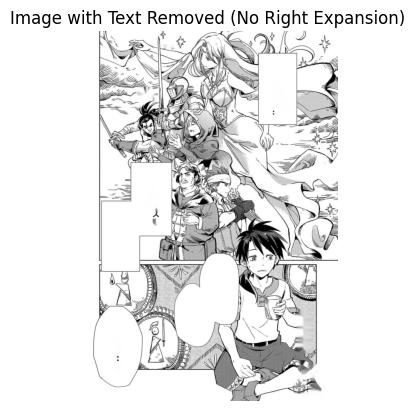

In [61]:
def inpaint_bboxes(image, bboxes, expand_px = 7):
    image_for_inpainting = image.copy()
    mask = np.zeros(image_for_inpainting.shape[:2], dtype=np.uint8)  # single-channel mask

    for box in bboxes:
        x_min, y_min, x_max, y_max = box

        # Expand each side safely
        x_min_exp = max(x_min - expand_px, 0)
        x_max_exp = min(x_max + expand_px, image_for_inpainting.shape[1])
        y_min_exp = max(y_min - expand_px, 0)
        y_max_exp = min(y_max + expand_px, image_for_inpainting.shape[0])

        # Draw on inpaint mask
        cv2.rectangle(mask, (x_min_exp, y_min_exp), (x_max_exp, y_max_exp), 255, -1)

    inpainted_image = cv2.inpaint(image_for_inpainting, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inpainted_image


inpainted_image = inpaint_bboxes(cv2_image, deepest_bboxes)

plt.imshow(inpainted_image)
plt.title("Image with Text Removed (No Right Expansion)")
plt.axis("off")
plt.show()

# Part 5: Insert text

In [62]:
def insert_text_into_image(image, text_results):
    image_with_text = image.copy()

    def compute_zone(text_node, expansion_ratio=0.8):
        if text_node['parent_bbox'] is not None:
            nx_min, ny_min, nx_max, ny_max = text_node['bbox']
            px_min, py_min, px_max, py_max = text_node['parent_bbox']
            x_center = (nx_min + nx_max) / 2
            y_center = (ny_min + ny_max) / 2

            x_exp = min(abs(x_center - px_min), abs(x_center - px_max)) * expansion_ratio
            y_exp = min(abs(y_center - py_min), abs(y_center - py_max)) * expansion_ratio

            return [
                int(x_center - x_exp),
                int(y_center - y_exp),
                int(x_center + x_exp),
                int(y_center + y_exp)
            ]
        return text_node['bbox']

    def zones_intersect(a, b):
        ax1, ay1, ax2, ay2 = a
        bx1, by1, bx2, by2 = b
        return not (ax2 <= bx1 or ax1 >= bx2 or ay2 <= by1 or ay1 >= by2)

    def shrink_zone(zone, shrink_ratio):
        x1, y1, x2, y2 = zone
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = (x2 - x1) * shrink_ratio / 2
        h = (y2 - y1) * shrink_ratio / 2
        return [int(cx - w), int(cy - h), int(cx + w), int(cy + h)]

    def resolve_overlaps(zones, max_iters=20, shrink_step=0.95):
        n = len(zones)
        final_zones = zones[:]
        for _ in range(max_iters):
            conflict = False
            for i in range(n):
                for j in range(i + 1, n):
                    if zones_intersect(final_zones[i], final_zones[j]):
                        final_zones[i] = shrink_zone(final_zones[i], shrink_step)
                        final_zones[j] = shrink_zone(final_zones[j], shrink_step)
                        conflict = True
            if not conflict:
                break
        return final_zones

    font = cv2.FONT_HERSHEY_SIMPLEX
    base_font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2

    def draw_wrapped_text_in_zone(img, text, zone, font, base_scale, color, thickness):
        x_min, y_min, x_max, y_max = zone
        box_width = x_max - x_min
        box_height = y_max - y_min

        def wrap_text(text, font_scale):
            words = text.split()
            lines, line = [], ""
            for word in words:
                test_line = (line + " " + word).strip()
                width, _ = cv2.getTextSize(test_line, font, font_scale, thickness)[0]
                if width <= box_width:
                    line = test_line
                else:
                    if line:
                        lines.append(line)
                    if cv2.getTextSize(word, font, font_scale, thickness)[0][0] > box_width:
                        # Even single word is too wide, force it in
                        lines.append(word)
                        line = ""
                    else:
                        line = word
            if line:
                lines.append(line)
            return lines

        def get_text_block_size(lines, font_scale):
            if not lines:
                return 0, 0
            (w, h), _ = cv2.getTextSize("A", font, font_scale, thickness)
            block_height = len(lines) * (h + 10)
            block_width = max(cv2.getTextSize(line, font, font_scale, thickness)[0][0] for line in lines)
            return block_width, block_height

        font_scale = base_scale
        for _ in range(30):
            lines = wrap_text(text, font_scale)
            tw, th = get_text_block_size(lines, font_scale)
            if tw <= box_width and th <= box_height:
                break
            font_scale *= 0.95
            if font_scale < 0.2:
                break

        # Center text
        text_start_y = y_min + (box_height - th) // 2 + int(cv2.getTextSize("A", font, font_scale, thickness)[0][1])
        for i, line in enumerate(lines):
            line_width = cv2.getTextSize(line, font, font_scale, thickness)[0][0]
            text_start_x = x_min + (box_width - line_width) // 2
            y = text_start_y + i * (cv2.getTextSize("A", font, font_scale, thickness)[0][1] + 10)
            cv2.putText(img, line, (text_start_x, y), font, font_scale, color, thickness, lineType=cv2.LINE_AA)

    # Step 1: Get and resolve text zones
    raw_zones = [compute_zone(node) for node in text_results]
    non_overlapping_zones = resolve_overlaps(raw_zones)

    # Step 2: Draw text in zones
    base_image = np.zeros_like(image_with_text)
    for i, node in enumerate(text_results):
        zone = non_overlapping_zones[i]
        text = node["translation"]["translation"]
        draw_wrapped_text_in_zone(base_image, text, zone, font, base_scale=base_font_scale, color=color, thickness=thickness)

    # Step 3: Invert colors where white text was drawn
    mask = base_image == 255
    image_with_text[mask] = 255 - image_with_text[mask]

    return image_with_text

final_image = insert_text_into_image(inpainted_image, text_results)

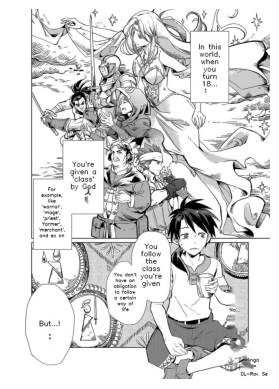

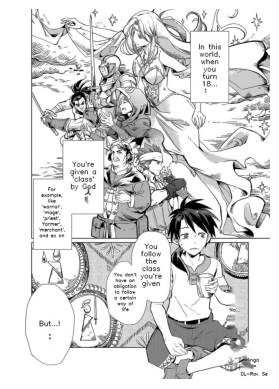

True

In [63]:
# Show
plt.imshow(final_image)
plt.axis("off")
plt.show()

output_folder = IMPORT_PARAMS.get("output_folder", "outputs")
os.makedirs(output_folder, exist_ok=True)
cv2.imwrite(os.path.join(output_folder, f"output for {input_file_name}.jpg"), cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))